In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from utils.data_loader import CrashDataLoader 
import geopy.distance as geo_distance

In [2]:
# Radius to remove accidents when performing K means
HOSPITAL_RADIUS = 12.5

### Load Data

In [3]:
data_loader = CrashDataLoader()

Loading data from: 
./data/2000 to 2005 ACCIDENT
./data/ACCIDENT


In [4]:
person_df = data_loader.load_file("PERSON.csv")
person_df["inj_level"] = pd.to_numeric(person_df["inj_level"], errors="coerce")
person_df = person_df.dropna(subset=["inj_level"])
person_df["inj_level"] = person_df["inj_level"].astype('int32')
person_df.shape

C:\Work\job\blunomy\utils\data_loader.py:12: DtypeWarning: Columns (0,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]
C:\Work\job\blunomy\utils\data_loader.py:12: DtypeWarning: Columns (6,9,10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]


(759976, 17)

In [6]:
accident_df = data_loader.load_file("ACCIDENT.csv")
org_hospital_distance_df = pd.read_csv("./data/NodeHospitalDistance.csv")

injury_df = person_df[["accident_no","inj_level"]].groupby(by=["accident_no"]).min()
injury_df = injury_df.join(accident_df[["accident_no","node_id"]].set_index("accident_no")).join(org_hospital_distance_df.set_index("node_id"), on="node_id")
injury_df = injury_df.rename(columns={"hospital_distance": "org_hospital_distance", "hospital_id": "org_hospital_id"})

C:\Work\job\blunomy\utils\data_loader.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]
C:\Work\job\blunomy\utils\data_loader.py:12: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]


In [7]:
node_df = data_loader.load_file("NODE.csv")
node_df = node_df.drop_duplicates(subset=["node_id"])
node_df["coordinate"] = list(zip(node_df.lat, node_df.long))
node_df

C:\Work\job\blunomy\utils\data_loader.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(Path(folder_path) / file_name) for folder_path in self.path_list]


,accident_no,node_id,node_type,amg_x,amg_y,lga_name,region name,deg urban name,lat,long,postcode no,vicgrid94_x,vicgrid94_y,lga_name_all,region_name,deg_urban_name,postcode_no,coordinate
0,12000000389,25264,N,2512514.427,2388780.839,DANDENONG,METROPOLITAN SOUTH EAST REGION,Metropolitan Excluding CBD,-38.002110,145.142480,3173.0,NaN,NaN,NaN,NaN,NaN,NaN,"(-38.00211, 145.14248)"
1,12000000554,42800,I,2506548.994,2392856.260,KINGSTON,METROPOLITAN SOUTH EAST REGION,Metropolitan Excluding CBD,-37.965450,145.074530,3192.0,NaN,NaN,NaN,NaN,NaN,NaN,"(-37.96545, 145.07453)"
2,12000000555,40101,I,2498299.136,2404214.048,PORT PHILLIP,METROPOLITAN NORTH WEST REGION,Metropolitan Excluding CBD,-37.863140,144.980670,3182.0,NaN,NaN,NaN,NaN,NaN,NaN,"(-37.86314, 144.98067)"
3,12000000559,127638,N,2500115.047,2395234.944,BAYSIDE,METROPOLITAN SOUTH EAST REGION,Metropolitan Excluding CBD,-37.944040,145.001310,3188.0,NaN,NaN,NaN,NaN,NaN,NaN,"(-37.94404, 145.00131)"
4,12000000586,57539,I,2505935.803,2401836.040,STONNINGTON,METROPOLITAN SOUTH EAST REGION,Metropolitan Excluding CBD,-37.884550,145.067480,3145.0,NaN,NaN,NaN,NaN,NaN,NaN,"(-37.88455, 145.06748)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326407,T20090046284,229107,N,NaN,NaN,WHITTLESEA,NaN,NaN,-37.676468,145.050491,NaN,2504453.781,2424931.347,WHITTLESEA,METROPOLITAN NORTH WEST REGION,MELB_URBAN,3082.0,"(-37.67646811, 145.0504909)"
326408,T20090046106,229103,N,NaN,NaN,WHITTLESEA,NaN,NaN,-37.645401,144.991064,NaN,2499211.462,2428380.388,WHITTLESEA,METROPOLITAN NORTH WEST REGION,MELB_URBAN,3076.0,"(-37.64540054, 144.9910643)"
326410,T20090047746,229114,N,NaN,NaN,BOROONDARA,NaN,NaN,-37.791877,145.093559,NaN,2508240.178,2412119.954,BOROONDARA,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,3104.0,"(-37.79187719, 145.0935586)"
326411,T20090044445,229087,N,NaN,NaN,INDIGO,NaN,NaN,-36.092861,146.702041,NaN,2653269.886,2599283.209,INDIGO,NORTH EASTERN REGION,RURAL_VICTORIA,3688.0,"(-36.09286128, 146.7020407)"


In [9]:
crash_coor_df = accident_df.join(node_df[["accident_no","lat","long"]].set_index("accident_no"), on="accident_no")[["accident_no","lat","long"]].dropna()
crash_coor_df = injury_df.join(crash_coor_df.set_index("accident_no")).dropna()
crash_coor_df

,inj_level,node_id,org_hospital_id,org_hospital_distance,lat,long
accident_no,,,,,,
12000000389,1,25264.0,3405.0,7.315271,-38.002110,145.142480
12000000554,2,42800.0,3425.0,5.015673,-37.965450,145.074530
12000000555,2,40101.0,10636.0,1.894277,-37.863140,144.980670
12000000559,2,127638.0,3425.0,2.375678,-37.944040,145.001310
12000000586,3,57539.0,3390.0,6.359619,-37.884550,145.067480
...,...,...,...,...,...,...
T20200018987,2,665599.0,3405.0,2.463386,-37.998038,145.212482
T20200019125,2,665832.0,12280.0,7.119641,-38.032257,145.268088
T20200019239,2,665835.0,2447.0,1.492807,-37.828081,144.983214


### Generate recommendations with K mean

In [8]:
# Functions to apply on dataframes

def get_min_hospital_distance(row, hospital_df):
    # Calculate min distance(km) hospital with (lat,long) coordinates
    hospital_id_list = list(hospital_df["hospital id"])
    hospital_coor_list = list(hospital_df["coordinate"])
    
    min_distance, min_hospital_id = None, -1

    try:
        for h_id,h_coor in zip(hospital_id_list, hospital_coor_list):
            _distance = geo_distance.distance(row["coordinate"],h_coor).km
            if min_distance is None or _distance < min_distance:
                min_hospital_id = h_id
                min_distance = _distance
        return min_hospital_id, min_distance
    except:
        return -1, -1
        
def get_min_hospital(row):
    # Return (hospital id with min distance, min distance(km))
    if row["new_hospital_distance"]<row["org_hospital_distance"]:
        return row["new_hospital_id"], row["new_hospital_distance"]
    else:
        return row["org_hospital_id"], row["org_hospital_distance"]

array([[142.1358024 , -34.23925653],
       [144.74692687, -37.57508086],
       [146.2319373 , -37.03042921],
       [142.81234418, -37.22514612],
       [149.27483408, -37.50426366],
       [145.55228779, -38.0604431 ],
       [142.93782894, -38.28404803],
       [144.61498589, -36.308144  ],
       [147.55108899, -37.04013648],
       [142.24617917, -36.75267587],
       [141.60168572, -38.26086957],
       [145.1373813 , -36.4142491 ],
       [146.73523302, -38.35400098],
       [144.11580756, -38.36953451],
       [142.92273401, -35.7498126 ],
       [144.0269547 , -37.41465142],
       [145.00967286, -37.3751878 ],
       [145.99940861, -36.37684188],
       [146.64016245, -36.31486662],
       [145.96016335, -37.9669985 ],
       [145.15844544, -38.3333826 ],
       [145.30060938, -37.54839439],
       [143.22240381, -36.47167918],
       [147.89539247, -37.75844494],
       [142.17258759, -36.19222249],
       [144.21639307, -37.02669838],
       [146.08710231, -38.58491399],
 

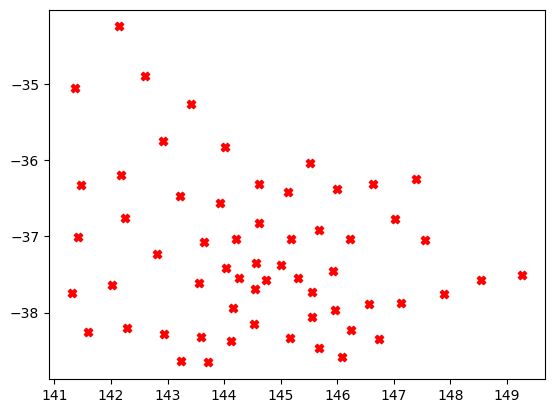

Calculating distance to ER: 100%|█████████████████████████████████████████████| 192756/192756 [31:46<00:00, 101.08it/s]


Crashes that have reduced distance: 64370


array([[144.74777647, -37.57476922],
       [146.50710048, -37.88515098],
       [142.32043912, -35.0779017 ],
       [141.60230141, -38.26217365],
       [145.37545938, -36.08799153],
       [143.61072118, -38.31975695],
       [143.31623942, -37.36997464],
       [146.78455818, -36.44373092],
       [145.53456361, -37.71630089],
       [144.6235038 , -36.8811888 ],
       [142.21079528, -36.10624355],
       [147.34076856, -37.98908293],
       [149.32014897, -37.50139912],
       [145.84608251, -38.43665679],
       [147.91551252, -37.74606854],
       [143.90246268, -35.77412426],
       [141.4704651 , -34.35828828],
       [144.53737745, -37.68692948],
       [145.68107277, -36.84675569],
       [142.77242362, -38.23069053],
       [144.21202383, -37.02586828],
       [145.99393401, -36.53654233],
       [144.13667207, -37.47063423],
       [145.14621174, -38.32694279],
       [143.43556391, -35.31369159],
       [146.49267026, -36.15757228],
       [141.75003308, -37.56408769],
 

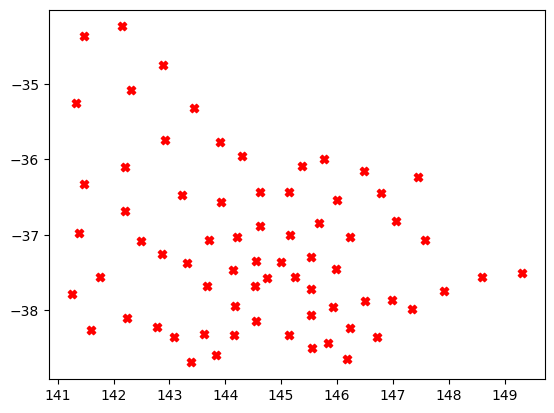

Calculating distance to ER: 100%|██████████████████████████████████████████████| 192756/192756 [36:45<00:00, 87.38it/s]


Crashes that have reduced distance: 65402


array([[142.19626482, -36.69441883],
       [144.74809025, -37.57313737],
       [145.98330568, -37.53108725],
       [142.13659475, -34.23911092],
       [143.59458872, -38.32762479],
       [147.1762612 , -36.28198388],
       [144.60160733, -36.31504382],
       [147.90989599, -37.81032479],
       [141.19762163, -37.87739447],
       [146.171253  , -38.65362279],
       [143.73124761, -37.05800879],
       [144.04687676, -35.79010583],
       [145.2384922 , -37.22399162],
       [145.53936649, -38.0839592 ],
       [142.22260848, -38.24184759],
       [146.02207278, -36.06053027],
       [144.57500696, -37.69018847],
       [142.93381021, -37.32905772],
       [143.97047822, -38.4360355 ],
       [146.9725192 , -38.00848626],
       [142.94621175, -35.78241384],
       [147.01843541, -36.79937878],
       [143.2003156 , -38.13982346],
       [145.55898489, -38.51530767],
       [144.11860108, -37.94025589],
       [149.32376209, -37.50043455],
       [144.23050371, -37.0472543 ],
 

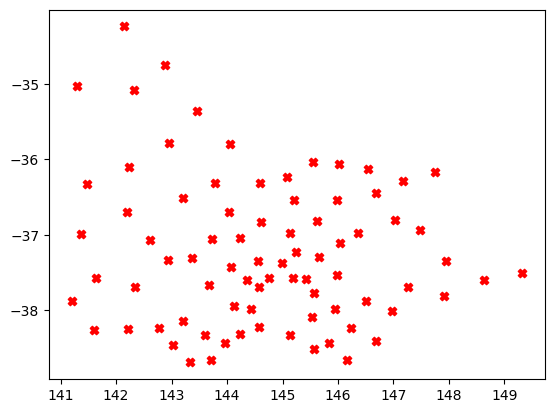

Calculating distance to ER: 100%|██████████████████████████████████████████████| 192756/192756 [41:34<00:00, 77.26it/s]


Crashes that have reduced distance: 67476


In [17]:
# Find new recommended sites and save coordinates, distance to files:
# - RecommendHospitalList_kmeans_{recommend count}.csv
# - NodeHospitalDistance_kmeans_{recommend count}.csv

for n_recommendations in list(range(1,10))+list(range(10,110,10)):
    # Find new sites with kmeans
    kmeans = KMeans(n_clusters=n_recommendations, n_init=10, random_state=0).fit(crash_coor_df[crash_coor_df["org_hospital_distance"]>HOSPITAL_RADIUS][["long", "lat"]])
    display(kmeans.cluster_centers_)
    plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], c="r", marker="X")
    plt.show()
    
    # Save new sites recommendations
    new_hospital_df = pd.DataFrame()
    new_hospital_df["coordinate"] = [tuple(coor_pair) for coor_pair in kmeans.cluster_centers_[:,::-1]]
    new_hospital_df["hospital id"] = range(1, len(new_hospital_df)+1)
    new_hospital_df["hospital id"] = new_hospital_df["hospital id"]*-1
    new_hospital_df.to_csv("./data/HospitalRecommendation/RecommendHospitalList_kmeans_{}.csv".format(n_recommendations), index=False)

    # Calculate node distance to ER
    new_hospital_distance_df = org_hospital_distance_df
    new_hospital_distance_df = new_hospital_distance_df.rename(columns={"hospital_distance": "org_hospital_distance", "hospital_id": "org_hospital_id"})
    new_node_df = node_df
    
    tqdm.pandas(desc='Calculating distance to ER')
    new_node_df[["new_hospital_id","new_hospital_distance"]] = new_node_df.progress_apply(lambda row: get_min_hospital_distance(row, hospital_df = new_hospital_df), axis=1, result_type="expand")
    new_hospital_distance_df = new_hospital_distance_df.join(new_node_df[["node_id","new_hospital_id","new_hospital_distance"]].set_index("node_id"), on="node_id")
    
    # Compare and keep min hospital distance    
    tqdm.pandas(desc='Selecting min distance hospital')
    new_hospital_distance_df[["hospital_id", "hospital_distance"]] = new_hospital_distance_df.apply(lambda row:get_min_hospital(row), axis=1, result_type="expand")
    new_hospital_distance_df["hospital_id"] = new_hospital_distance_df["hospital_id"].astype("int64")

    # Save new hospital distance
    new_hospital_distance_df[["node_id", "hospital_id", "hospital_distance"]] .to_csv("./data/HospitalRecommendation/NodeHospitalDistance_kmeans_{}.csv".format(n_recommendations), index=False)

    # See impact of new chosen sites
    new_injury_df = injury_df.join(new_hospital_distance_df[["node_id","hospital_id","hospital_distance"]].set_index("node_id"), on="node_id")
    print("Crashes that have reduced distance: {}".format(sum(new_injury_df["hospital_distance"] != new_injury_df["org_hospital_distance"])))